# Final Project Submission

Please fill out:
* Student name: __Paul Williams__
* Student pace: __full time__
* Scheduled project review date/time: __03/23/2020__
* Instructor name: __Dave Baker__

# Data Cleaning

## Imports:

In [1]:
# Data Frame & Visualization libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Statistics and regression libraries
import math
import statistics as stats
import numpy as np
from sklearn.linear_model import LinearRegression

# Feature engineering imports

from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.preprocessing import PolynomialFeatures,StandardScaler

# Validation imports
from sklearn.model_selection import train_test_split,KFold,cross_validate

# Regularization imports
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,LassoLarsIC



/Users/paulwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## The Data set

In [2]:
housing_df = pd.read_csv('data-files/kc_house_data.csv')
print("Number of row's before cleaning: ", housing_df.shape[0])
print("Number of columns before cleaning: ", housing_df.shape[1])
housing_df.head(3)

Number of row's before cleaning:  21597
Number of columns before cleaning:  21


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


In [134]:
# Data types for each columns
print(housing_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  yr_built       21597 non-null  int64  
 12  is_duplicated  21597 non-null  bool   
 13  land           21597 non-null  int64  
dtypes: bool(1), float64(4), int64(8), object(1)
memory usage: 2.2+ MB
None


## Drop unneeded columns

In [4]:
# Run this cell only once 
columns = ['view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
housing_df.drop(axis=1, columns=columns, inplace=True)
print("Number of columns after the drop: ", housing_df.shape[1])
housing_df.head(3)

Number of columns after the drop:  12


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933


## Missing Values

In [5]:
print("Total missing values:", housing_df.isnull().sum().sum())
housing_df.isnull().sum()

Total missing values: 2376


id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64

### Dealing with them:

In [6]:
print("Waterfront's values:", list(housing_df.waterfront.unique()))

Waterfront's values: [nan, 0.0, 1.0]


we can tell that waterfront is using binary 1 as yes and 0 as no. We can try to look up the houses based on their lat and long numbers and create a for loop to assign them with their appropriate binary value
https://www.zillow.com/seattle-wa/waterfront/?searchQueryState={%22pagination%22:{},%22mapBounds%22:{%22west%22:-122.53552677144053,%22east%22:-122.15443851460459,%22south%22:47.417845631013456,%22north%22:47.80806107176697},%22regionSelection%22:[{%22regionId%22:16037,%22regionType%22:6}],%22isMapVisible%22:true,%22mapZoom%22:11,%22filterState%22:{%22keywords%22:{%22value%22:%22waterfront%22},%22sortSelection%22:{%22value%22:%22globalrelevanceex%22},%22isPreMarketForeclosure%22:{%22value%22:false},%22isPreMarketPreForeclosure%22:{%22value%22:false}},%22isListVisible%22:true}

# Exploratory Data Analysis

## Check Duplicates

In [34]:
 housing_df.duplicated().any() # check for duplicates

False

In [8]:
# We need to check if our ID's are duplicated because that would mean we may have the same houses
print("There are", housing_df['id'].duplicated().sum(), "duplicate entries")

There are 177 duplicate entries


In [9]:
print("Number of houses duplicated: ", housing_df['id'].duplicated().sum())


Number of houses duplicated:  177


In [21]:
housing_df['is_duplicated'] = housing_df['id'].duplicated()
housing_df.query('is_duplicated== True').loc[:, ['id', 'date','price', 'is_duplicated']].sort_values('id')

,id,date,price,is_duplicated
2495,1000102,4/22/2015,300000.0,True
16801,7200179,4/24/2015,175000.0,True
11422,109200390,10/20/2014,250000.0,True
12406,123039336,12/8/2014,244900.0,True
7786,251300110,1/14/2015,358000.0,True
...,...,...,...,...
2492,9407110710,2/26/2015,322000.0,True
4918,9809000020,3/13/2015,1940000.0,True
6340,9828200460,1/6/2015,430000.0,True
15186,9834200305,2/10/2015,615000.0,True


## Outliers

In [11]:
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,3.409825,7.657915,1970.999676
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.650546,1.173200,29.375234
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,1900.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1975.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,1997.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000


In [136]:
# Query out houses with similar dimensions to our outlier then take the median bedrooms for those dimensions
# Median ignores the fact that the outlier is actually in this list
median_outlier = housing_df.query("bathrooms<=1.75 and sqft_living<2000 and floors==1").median()
median_outlier

id               3.841150e+09
price            3.299410e+05
bedrooms         3.000000e+00
bathrooms        1.000000e+00
sqft_living      1.270000e+03
sqft_lot         7.740000e+03
floors           1.000000e+00
waterfront       0.000000e+00
condition        3.000000e+00
grade            7.000000e+00
yr_built         1.955000e+03
is_duplicated    0.000000e+00
land             9.100000e+03
dtype: float64

In [141]:
print("Median bedrooms for houses with those dimensions is: ", int(median_outlier[2]))

Median bedrooms for houses with those dimensions is:  3


## Fill outlier

In [35]:
housing_df.query('bedrooms==33')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,is_duplicated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,5,7,1947,False


In [145]:
housing_df['bedrooms'].replace(33, median_outlier[2], inplace=True)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,is_duplicated,land
15856,2402100895,6/25/2014,640000.0,3,1.75,1620,6000,1.0,0.0,5,7,1947,False,7620


## Question 1
What is the relationship between my variables like?

### Visualization 1

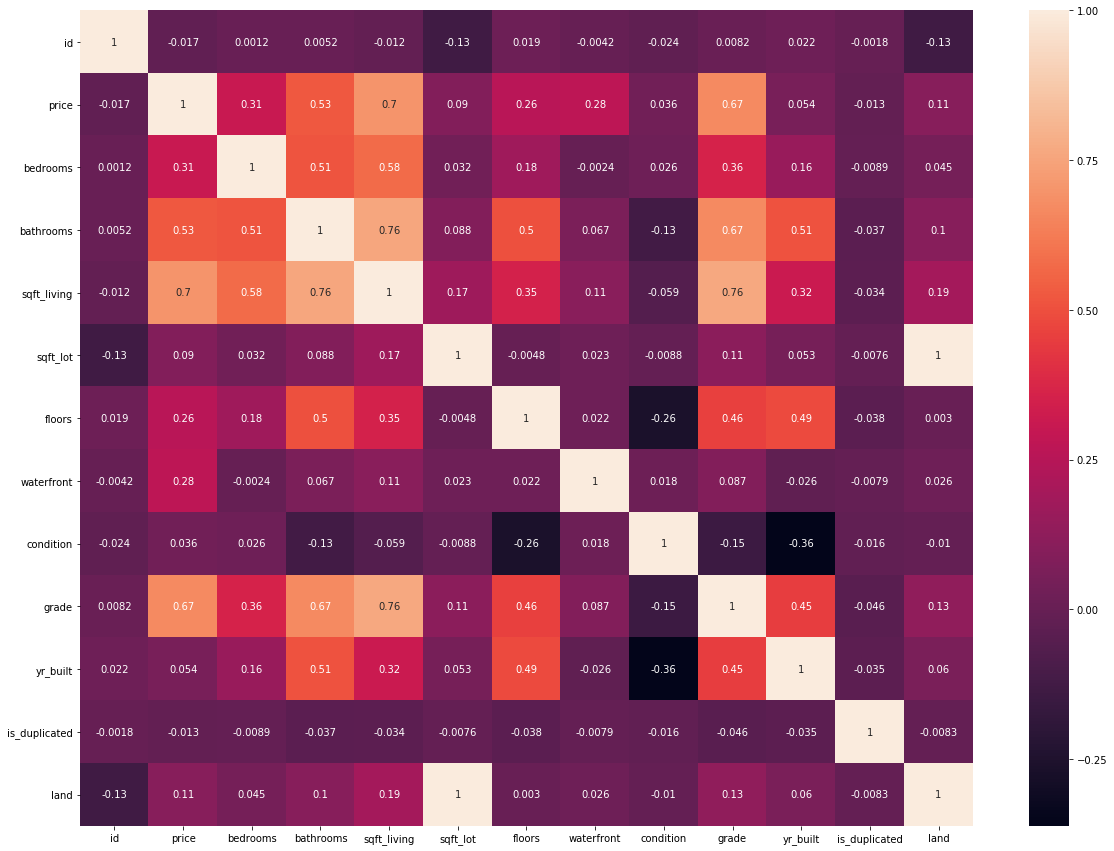

In [49]:
plt.subplots(figsize=(20,15))
sns.heatmap(housing_df.corr(), annot=True)

In [15]:
housing_df.loc[:, ['floors', 'waterfront', 'price']].describe()

,floors,waterfront,price
count,21597.000000,19221.000000,2.159700e+04
mean,1.494096,0.007596,5.402966e+05
std,0.539683,0.086825,3.673681e+05
min,1.000000,0.000000,7.800000e+04
25%,1.000000,0.000000,3.220000e+05
50%,1.500000,0.000000,4.500000e+05
75%,2.000000,0.000000,6.450000e+05
max,3.500000,1.000000,7.700000e+06


There will be a problem with multi-colinearity. If my features correlate .7 or higher between each other i will have to decide how to select or extract them.

## Question 2
Does a house with more bathrooms than bedrooms tend to sell more?


In [26]:
bed_bath_df = housing_df.loc[:,['price', 'bathrooms', 'bedrooms']]
bed_bath_df['bathroom_count']= bed_bath_df['bathrooms'].apply(np.ceil)
bed_bath_df

,price,bathrooms,bedrooms,bathroom_count
0,221900.0,1.00,3,1.0
1,538000.0,2.25,3,3.0
2,180000.0,1.00,2,1.0
3,604000.0,3.00,4,3.0
4,510000.0,2.00,3,2.0
...,...,...,...,...
21592,360000.0,2.50,3,3.0
21593,400000.0,2.50,4,3.0
21594,402101.0,0.75,2,1.0
21595,400000.0,2.50,3,3.0


In [33]:
bed_bath_df.query('bathroom_count>=bedrooms').describe()

,price,bathrooms,bedrooms,bathroom_count
count,6.632000e+03,6632.000000,6632.000000,6632.000000
mean,6.323105e+05,2.580029,2.929885,3.067551
std,4.783764e+05,0.701589,0.703782,0.751787
min,8.000000e+04,0.500000,1.000000,1.000000
25%,3.603000e+05,2.250000,3.000000,3.000000
50%,5.000000e+05,2.500000,3.000000,3.000000
75%,7.225750e+05,2.750000,3.000000,3.000000
max,7.700000e+06,8.000000,7.000000,8.000000


### Visualization 2
Scatter plot linear line with highly correlated features

## Question 3

The correlation between bedrooms and price is only .31 this seems quite low. Maybe bedrooms for houses not in the inner city area are not sought out for. And inner city houses with high bedrooms give a higher correlation to house price.

In [16]:
bedrooms_df = pd.read_csv('data-files/kc_house_data.csv', usecols=['price','bedrooms','zipcode'])
bedrooms_df.head()

,price,bedrooms,zipcode
0,221900.0,3,98178
1,538000.0,3,98125
2,180000.0,2,98028
3,604000.0,4,98136
4,510000.0,3,98074


Mean house price is 540k. Maybe if we filter out those houses and do a correlation matrix we will see a higher correlation between price and bedrooms?

zipcode that has 98112 seem to be the highest correlation between bedroom and price <br>
i used this map to see: https://www.zipmap.net/Washington/King_County/Z_Central_District.htm

In [17]:
bedrooms_df.query('zipcode==98122').corr()

,price,bedrooms,zipcode
price,1.000000,0.352157,NaN
bedrooms,0.352157,1.000000,NaN
zipcode,NaN,NaN,NaN


### Visualization 3

Houses with bathrooms greater than bedrooms:

In [18]:
housing_df.loc[:,['price', 'bedrooms', 'bathrooms']].query('bathrooms>bedrooms').corr()

,price,bedrooms,bathrooms
price,1.000000,0.605940,0.656697
bedrooms,0.605940,1.000000,0.949219
bathrooms,0.656697,0.949219,1.000000


# Regression Model

the sqft living is such a powerful predictor but i feel like it’s not telling the whole truth
and including it makes you run into multi collinearity issues with other predictors. This would mean i would have to drop the other predictors and use sqft living only if i wanted to include it.
I feel like my model would heavily generalize based on the sqft living feature and
if it was given a data set of houses in bad neighbourhoods that had less bathrooms than rooms but high sqft living it would get the price prediction wrong a lot of the time.
so i am thinking of using more predictors with less correlation to price and less correlation with each other and dropping sqft living completely.
I honestly think a combination of bathrooms, floors, waterfront and grade tell the story better

Bathrooms, waterfront, and grade, maybe floors

In [60]:
housing_df.query('sqft_living>1000 and bathrooms<=bedrooms and floors>=1').describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,land
count,1.925700e+04,1.925700e+04,19257.000000,19257.000000,19257.000000,1.925700e+04,19257.000000,17159.000000,19257.000000,19257.000000,19257.000000,1.925700e+04
mean,4.580418e+09,5.451861e+05,3.496079,2.149777,2151.984733,1.526361e+04,1.502648,0.006585,3.419484,7.721140,1971.999117,1.741559e+04
std,2.879531e+09,3.408644e+05,0.870987,0.696612,839.074205,3.990458e+04,0.531851,0.080886,0.648870,1.101905,28.720509,4.004690e+04
min,1.000102e+06,9.500000e+04,1.000000,0.500000,1008.000000,5.200000e+02,1.000000,0.000000,1.000000,4.000000,1900.000000,1.622000e+03
25%,2.122059e+09,3.300000e+05,3.000000,1.750000,1528.000000,5.250000e+03,1.000000,0.000000,3.000000,7.000000,1954.000000,7.399000e+03
50%,3.904931e+09,4.630000e+05,3.000000,2.250000,1990.000000,7.800000e+03,1.500000,0.000000,3.000000,7.000000,1976.000000,9.827000e+03
75%,7.308900e+09,6.500000e+05,4.000000,2.500000,2590.000000,1.090000e+04,2.000000,0.000000,4.000000,8.000000,1996.000000,1.328000e+04
max,9.900000e+09,7.060000e+06,33.000000,7.500000,10040.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000,1.652659e+06


### Feature Selection & Extraction

one hot encode yr_built with - old, modern, new

In [76]:
housing_df.query('yr_built>=1980 and yr_built<=2000').corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,is_duplicated,land
id,1.000000,-0.047550,0.003956,-0.038335,-0.047463,-0.202621,0.005552,-0.005750,-0.034060,-0.015597,-0.006473,-0.011597,-0.202633
price,-0.047550,1.000000,0.307062,0.546109,0.753429,0.134479,0.233391,0.396508,0.048723,0.739405,0.114459,0.017853,0.147461
bedrooms,0.003956,0.307062,1.000000,0.552567,0.529377,0.021217,0.181474,0.011126,-0.010269,0.331302,0.123452,0.013319,0.030643
bathrooms,-0.038335,0.546109,0.552567,1.000000,0.705637,0.077010,0.365074,0.134860,-0.045699,0.544721,0.294564,0.020034,0.089372
sqft_living,-0.047463,0.753429,0.529377,0.705637,1.000000,0.222533,0.296314,0.172628,-0.013490,0.797701,0.189435,0.004705,0.239580
sqft_lot,-0.202621,0.134479,0.021217,0.077010,0.222533,1.000000,-0.022361,-0.002407,0.013528,0.122579,0.001233,-0.009416,0.999846
floors,0.005552,0.233391,0.181474,0.365074,0.296314,-0.022361,1.000000,0.043138,-0.134995,0.335952,0.398891,-0.004977,-0.016943
waterfront,-0.005750,0.396508,0.011126,0.134860,0.172628,-0.002407,0.043138,1.000000,0.039546,0.140359,-0.000887,-0.006379,0.000725
condition,-0.034060,0.048723,-0.010269,-0.045699,-0.013490,0.013528,-0.134995,0.039546,1.000000,-0.057556,-0.283631,0.010027,0.013229
grade,-0.015597,0.739405,0.331302,0.544721,0.797701,0.122579,0.335952,0.140359,-0.057556,1.000000,0.207708,0.002905,0.136406


### Linear Regression

In [146]:
regression_baseline = housing_df.loc[:,['price', 'grade', 'yr_built', 'bedrooms', 'sqft_living']]
regression_baseline

,price,grade,yr_built,bedrooms,sqft_living
0,221900.0,7,1955,3,1180
1,538000.0,7,1951,3,2570
2,180000.0,6,1933,2,770
3,604000.0,7,1965,4,1960
4,510000.0,8,1987,3,1680
...,...,...,...,...,...
21592,360000.0,8,2009,3,1530
21593,400000.0,8,2014,4,2310
21594,402101.0,7,2009,2,1020
21595,400000.0,8,2004,3,1600


(21597, 5)


,price,grade,yr_built,bedrooms,sqft_living
0,221900.0,7,1955,3,1180
1,538000.0,7,1951,3,2570
2,180000.0,6,1933,2,770
3,604000.0,7,1965,4,1960
4,510000.0,8,1987,3,1680


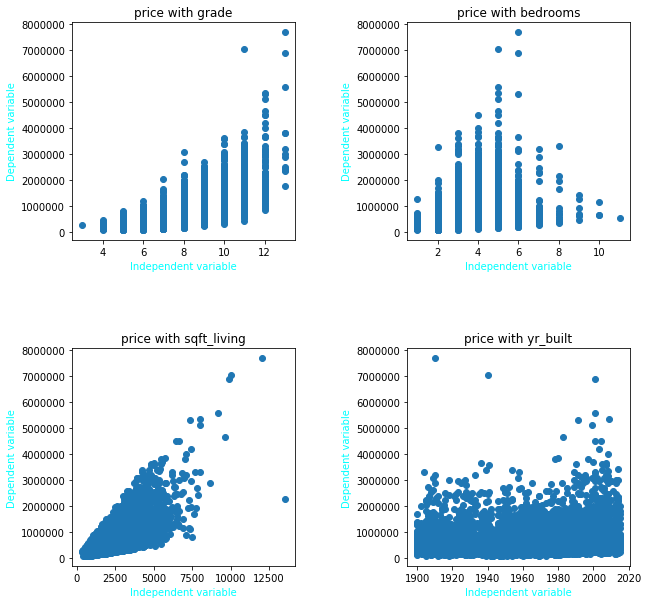

In [147]:
y = regression_baseline.loc[:,['price']]
x = regression_baseline.loc[:,['grade']]
x2 = regression_baseline.loc[:,['bedrooms']]
x3 = regression_baseline.loc[:,['sqft_living']]
x4 = regression_baseline.loc[:,['yr_built']]


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)



ax[0][0].set_xlabel('Independent variable', color="cyan")
ax[0][0].set_ylabel('Dependent variable', color="cyan")
ax[0][1].set_xlabel('Independent variable', color="cyan")
ax[0][1].set_ylabel('Dependent variable', color="cyan")
ax[1][0].set_xlabel('Independent variable', color="cyan")
ax[1][0].set_ylabel('Dependent variable', color="cyan")
ax[1][1].set_xlabel('Independent variable', color="cyan")
ax[1][1].set_ylabel('Dependent variable', color="cyan")

ax[0][0].title.set_text('price with grade')
ax[0][0].scatter(x, y)
ax[0][1].title.set_text('price with bedrooms')
ax[0][1].scatter(x2, y)
ax[1][0].title.set_text('price with sqft_living')
ax[1][0].scatter(x3, y)
ax[1][1].title.set_text('price with yr_built')
ax[1][1].scatter(x4, y)





print(regression_baseline.shape)
regression_baseline.head()

### Visualization 4